# Reparameterization Trick

## Introduction

Previously, we learned how Variational Autoencoders (VAEs) work and how their loss function is defined. However, we faced a challenge when trying to compute the gradient of the loss function—something essential for training the network.

The problem came from how we sample the latent variable \$\mathbf{h}\$ from the encoder's output distribution \$q\_\phi(h|x)\$. Since \$\mathbf{h}\$ is randomly sampled, we can't directly compute gradients with respect to the encoder parameters \$\phi\$, which makes optimization difficult due to high variance.

To fix this, we use the **reparameterization trick**. It rewrites the expectation in the loss function in a way that no longer depends directly on \$\phi\$ during sampling, making the gradients more stable and easier to compute.

Here’s the key idea: instead of sampling \$\mathbf{h}\$ directly, we express it as:

$$
\mathbf{h} = \mu + \sigma \cdot \epsilon
$$

* \$\mu\$ and \$\sigma\$ are the mean and standard deviation produced by the encoder.
* \$\epsilon\$ is a random sample from a standard normal distribution (mean 0, variance 1).

This formulation allows us to keep the randomness separate from the parameters we're optimizing. As a result, we can compute gradients with respect to \$\phi\$ more easily and with lower variance.


## Problem Framing

Before we dive into the solution (the reparameterization trick), it’s important to understand the **problem** clearly.

As discussed earlier, the **variational lower bound** (our training objective) is:

$$
\mathcal{L}(\phi, \theta) = \mathbb{E}_{h \sim q_\phi(h|x)} [\log P_\theta(x|h)] - \text{KL}(q_\phi(h|x) || P(h))
$$

Now, let’s focus on the first term:

$$
\mathbb{E}_{h \sim q_\phi(h|x)} [\log P_\theta(x|h)]
$$

This term depends on how we sample \$\mathbf{h}\$ from the encoder's distribution. According to \[Kingma et al., 2013], the naive gradient of this term with respect to the encoder parameters \$\phi\$ is estimated as:

$$
\nabla_\phi \mathbb{E}_{h \sim q_\phi(h|x)} [\log P_\theta(x|h)]
\approx \frac{1}{L} \sum_{l=1}^L \log P_\theta(x|h^{(l)}) \cdot \nabla_\phi \log q_\phi(h^{(l)}|x)
$$

Here:

* \$L\$ is the number of samples (used for Monte Carlo estimation).
* \$h^{(l)}\$ is a sample from the encoder distribution \$q\_\phi(h|x)\$.

The **main issue** with this gradient estimator is **high variance**. But what does *high variance* mean?

Imagine we’re trying to estimate a value that averages to 1. If our sample values are close to 1—like 1.1, 0.9, 1.05—then the average will also be close to 1. This is a **low-variance estimate**.

But now imagine 99 of the samples are 0, and 1 sample is 100. The average might still be around 1, but you'd need **a huge number of samples** to be sure. This is a **high-variance estimate**, and it’s unreliable.

That’s exactly the problem here: without the reparameterization trick, the gradient estimate has high variance, making learning unstable or even impossible.

Many sources say we can’t backpropagate through random nodes—but that’s not entirely true. The real problem is that **sampling directly from \$q\_\phi(h|x)\$ doesn’t give a reliable estimate of the gradient**, even if we try to backpropagate.

Now that we clearly understand the issue, let’s explore how the **reparameterization trick** helps solve it.

## Solution through Reparameterization

Optimizing the parameters of the network requires a good-estimate of the gradients. One of the main contributions of the VAE research paper is the low-variance gradient estimator using the reparameterization trick, an alternate method for generating samples $\mathbf{h}$ from our approximate posterior $q_\phi(h|x)$.

Under certain conditions, it is often possible to express random variable $\mathbf{h}$ as a deterministic variable $\mathbf{h} = g_\phi (\mathbf{\epsilon} , \mathbf{x})$, where $\epsilon$ is a sampled noise variable from a simple distribution $P(\epsilon)$ like standard normal distribution, $\mathcal{N}(0,1)$.

Following steps are performed in reparameterization trick:

- First we sample a random noise variable $\epsilon$ from distribution $\mathcal{N}(0,1)$

<center>$\epsilon \sim \mathcal{N}(0,1)$</center>

- Then, apply deterministic transformation which maps noise variables to more complex distribution. In this case, the complex distribution is encoder probability distribution function $q_\phi(h|x)$

<center>$\mathbf{h} = g_\phi (\mathbf{\epsilon} , \mathbf{x})$</center>

So, instead of sampling latent variable from approximate posterior, we sample the noise variable from the standard normal distribution and express latent variable $\mathbf{h}$ as

<center>$\mathbf{h} = \mu + \sigma . \epsilon$</center>

where, we have stored mean ($\mu$) and standard deviation ($\sigma$) as the last layer of VAE's encoder. $\sigma$ is for scaling the sample noise and $\mu$ add location (shift) to the noise resulting in distribution similar to our original approximate posterior distribution. Following figure will help you visualized the process a bit more.
<center>
<figure>
<img src="https://i.postimg.cc/j2JdL9d6/original-vs-reparameterization-trick.jpg" alt="Difference in original and reparameterized version">
<figcaption align="center"> Fig: Difference between original and reparametarization VAE</figcaption>
</figure>
</center>


Now, our latent variable $\mathbf{h}$ is deterministic, this changes the scenario for computing backpropagation. The gradient of the expectation term in variational lower bound can now be written as:

$$
\nabla_\phi \mathbb{E}_{h \sim {q_\phi(h|x)}} [logP_\theta(x|h)] = \nabla_\phi \mathbb{E}_{\epsilon \sim P(\epsilon)}[logP_\theta(x|g_\phi (\epsilon, x))]  = \mathbb{E}_{\epsilon \sim P(\epsilon)}[\nabla_\phi logP_\theta(x|g_\phi (\epsilon, x))]
$$

This estimate of the gradient has a lower amount of variance than the original estimator [Geoffrey et al. (2017)] and allows us to develop models that weren't feasible before.


The loss function of VAE isn't changed though, only the process of computing its gradient is changed. Now, process involved in training VAE changes a bit and stated as follows:

<center>
<figure>
<img src="https://i.postimg.cc/HkbzQsPR/vae-schematics-with-reparametrization.jpg" alt="VAE with reparameterization trick">
<figcaption align="center">Fig: VAE Schematics with reparameterization</figcaption>
</figure>
</center>

1. First, encode the input $\mathbf{x}$ as latent distribution $q_\phi(h|x)$ = $q_\phi(\mu_x, \sigma_x^2)$ = $ \mathcal{N}(\mu_x, \sigma_x^2)$.
2. Second, sample random noise variable $\epsilon \sim \mathcal{N}(0,1)$ and compute deterministic latent variable, $\mathbf{h} = \mu_x + \sigma_x . \epsilon$
3. Third, Decode the reconstructed output $\mathbf{x'}$ from the latent variable $\mathbf{h}$ using decoder's distribution $P_\theta(x|h)$.
4. Finally, compute the loss term and its gradients w.r.to encoder, decoder parameters i.e. $\nabla_{\phi, \theta}$ backpropagate it through the network.

Now that we have learned how to properly model VAE for finding low-variance gradients, tuning the parameters of the model are possible. We can now generate new data from the variational autoencoder. In the next sub-section, we will be learning to apply reparameterization trick and find the KL-divergence using PyTorch.


## Implementation using PyTorch

Once again, we will be using MNIST dataset as our input data for implementation of VAE using reparameterization trick. Specification of the neural network constructed are as follows:

**Import required libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader

print(torch.__version__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

2.6.0+cu124


device(type='cuda', index=0)

**Initialize the hyperparameters of the network**

In [2]:
num_epochs = 50         # no of epochs for training
batch_size = 64         # Batch_size per iteration
learning_rate = 2e-4    # learning rate for optimizer

**Load Dataset**

MNIST dataset consists of 60000 training and 10000 test images each of size 28x28 pixels. First we load the dataset into our variables (labels not required), then change the dimension of images to 784x1 to input to our fully-connected neural network. Also, normalization of pixel values between 0 and 1 is conducted.

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=2
)

testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=2
)

image_shape = trainset[0][0].size()
image_shape, trainset.class_to_idx

(torch.Size([1, 28, 28]),
 {'0 - zero': 0,
  '1 - one': 1,
  '2 - two': 2,
  '3 - three': 3,
  '4 - four': 4,
  '5 - five': 5,
  '6 - six': 6,
  '7 - seven': 7,
  '8 - eight': 8,
  '9 - nine': 9})

**Defining architecture of VAE**

A point to note in implementation, the neural network can output values which might be positive or negative but $\sigma^2$ needs to be positive for the distribution to be well-defined. Also, calculating gradient of -ve values needs to be tackled. So, **instead of storing variance of the distribution, we store the log scale of variance as a node to ensure that we get only +ve values for variance from our encoder function.** Later we use exponential function where needed to compute variance of the log-scale.

| **Section**            | **Parameter**               | **Value / Description**                                                                        |
| ---------------------- | --------------------------- | ---------------------------------------------------------------------------------------------- |
| **Input**              | Input Dimension             | 784 (Flattened 28×28 image)                                                                    |
| **Encoder**            | Hidden Layers               | 512 → 256 (can be changed)                                                                     |
|                        | Activation Function         | ReLU                                                                                           |
|                        | Output Units                | Mean (\$\mu\$): 25 <br> Log-Variance (\$\log \sigma^2\$): 25                                   |
| **Reparameterization** | Latent Space Dimension      | 25                                                                                             |
|                        | Noise Vector (\$\epsilon\$) | 25-dimensional, sampled from \$\mathcal{N}(0, 1)\$                                             |
|                        | Reparameterization Formula  | \$\mathbf{h} = \mu + \sigma \cdot \epsilon\$ <br> \$\sigma = \exp(0.5 \cdot \text{log\_var})\$ |
| **Decoder**            | Hidden Layers               | 256 → 512 (mirrors encoder)                                                                    |
|                        | Activation Function         | ReLU                                                                                           |
| **Output Layer**       | Output Dimension            | 784 (same as input)                                                                            |
|                        | Activation Function         | Sigmoid (to squash values between 0 and 1)   |

                                       
**Training Settings**

|**Parameter** | **Value / Description**                         |
| ------------- | ----------------------------------------------- |
| Optimizer     | AdamW (learning rate defined via hyperparameter) |
| Batch Size    | 64 (can be modified)                           |
| Epochs        | 50 (can be modified)                            |
| Loss Function | Mean Squared Error (MSE) + KL Divergence        |


In [4]:
class Variational_autoencoder(nn.Module):
    def __init__ (self, image_shape, h1_dim, h2_dim, h_dim):
        """Initializing the layers of variational autoencoder"""
        super().__init__()
        self.image_shape = image_shape

        self.encoder_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(np.prod(image_shape), h1_dim),
            nn.LeakyReLU(negative_slope=0.02),
            nn.Linear(h1_dim, h2_dim),
            nn.LeakyReLU(negative_slope=0.02),
        )

        self.mean_layer = nn.Linear(h2_dim, h_dim)
        self.log_var_layer = nn.Linear(h2_dim, h_dim)

        self.decoder_layers = nn.Sequential(
            nn.Linear(h_dim, h2_dim),
            nn.LeakyReLU(negative_slope=0.02),
            nn.Linear(h2_dim, h1_dim),
            nn.LeakyReLU(negative_slope=0.02),
            nn.Linear(h1_dim, np.prod(image_shape)),
            nn.Sigmoid(),
        )

    def encoder(self,x):
        """Encoder part of VAE"""
        enc = self.encoder_layers(x)
        return self.mean_layer(enc), self.log_var_layer(enc)

    def reparameterization(self, mean, log_var):
        """Reparameterization Trick Implementation"""
        stddev = torch.exp(0.5*log_var)
        eps = torch.randn_like(stddev, device=stddev.device)
        return mean + stddev * eps

    def decoder (self, h):
        """Decoder part of VAE"""
        dec = self.decoder_layers(h)
        return dec.view((-1, *self.image_shape))  # Reshape back to input image size

    def forward(self, inputs):
        mean, log_var = self.encoder(inputs)
        h = self.reparameterization(mean, log_var)
        x_reconstructed = self.decoder(h)
        return x_reconstructed, mean, log_var

**Setting units for hidden layer and initial compilation of model**

In this step, we initialize VAE model with units per layer. Then we set the optimizer as **AdamW** and **MSE loss** and **KL Divergence** for calculating gradients.

In [5]:
def KLDivLoss(mean, log_var):
    return -torch.mean(0.5 * torch.sum(1 + log_var - torch.square(mean) - torch.exp(log_var), dim = -1), dim = 0)

h_dim = 25
model = Variational_autoencoder(image_shape, 512, 256, h_dim).to(device)
model

Variational_autoencoder(
  (encoder_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): LeakyReLU(negative_slope=0.02)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.02)
  )
  (mean_layer): Linear(in_features=256, out_features=25, bias=True)
  (log_var_layer): Linear(in_features=256, out_features=25, bias=True)
  (decoder_layers): Sequential(
    (0): Linear(in_features=25, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.02)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.02)
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [6]:
reconstruction_loss_object = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

**Training the VAE(Forward pass + backprop)**

First, each batch of input are fed into the model, which returns reconstructed input, mean and log_var matrix. Then, we find the actual loss of VAE network using both loss object created above. Finally, Optimizer is used to decrease the loss function of the network. Thus, the network trains.

In [7]:
reconstruction_losses_avg = []
kl_divs_avg = []
losses_avg = []

test_recon_losses_avg = []
test_kl_divs_avg = []
test_losses_avg = []

for epoch in range(num_epochs):
    reconstruction_losses = []
    kl_divs = []
    losses = []

    model.train()
    pbar = tqdm(trainloader)

    for batch_idx, (X, _) in enumerate(pbar):
        X = X.to(device)

        optimizer.zero_grad()

        X_reconstructed, mean, log_var = model(X)

        recon_loss = reconstruction_loss_object(X_reconstructed, X) * np.prod(image_shape)
        kl_loss = KLDivLoss(mean, log_var)
        loss = recon_loss + kl_loss

        loss.backward()
        optimizer.step()

        reconstruction_losses.append(recon_loss.item())
        kl_divs.append(kl_loss.item())
        losses.append(loss.item())

        pbar.set_description(f"Epoch {epoch + 1}/{num_epochs} Reconstruction Loss: {reconstruction_losses[-1]:.3f}, KLDivLoss: {kl_divs[-1]:.3f}, Loss: {losses[-1]:.3f}")

    reconstruction_losses_avg.append(np.mean(reconstruction_losses))
    kl_divs_avg.append(np.mean(kl_divs))
    losses_avg.append(np.mean(losses))
    pbar.set_description(f"Epoch {epoch + 1}/{num_epochs} Reconstruction Loss: {reconstruction_losses_avg[-1]:.3f}, KLDivLoss: {kl_divs_avg[-1]:.3f}, Loss: {losses_avg[-1]:.3f}")

    ### TEST LOOP ###
    model.eval()
    test_recon_losses = []
    test_kl_divs = []
    test_losses = []

    with torch.no_grad():
        for X_test, _ in testloader:
            X_test = X_test.to(device)
            X_reconstructed, mean, log_var = model(X_test)

            recon_loss = reconstruction_loss_object(X_reconstructed, X_test) * np.prod(image_shape)
            kl_loss = KLDivLoss(mean, log_var)
            loss = recon_loss + kl_loss

            test_recon_losses.append(recon_loss.item())
            test_kl_divs.append(kl_loss.item())
            test_losses.append(loss.item())

    test_recon_losses_avg.append(np.mean(test_recon_losses))
    test_kl_divs_avg.append(np.mean(test_kl_divs))
    test_losses_avg.append(np.mean(test_losses))

    if (epoch+1) % 5 == 0:
        print(f"[Test] Epoch {epoch + 1}/{num_epochs} Reconstruction Loss: {test_recon_losses_avg[-1]:.3f}, KLDivLoss: {test_kl_divs_avg[-1]:.3f}, Loss: {test_losses_avg[-1]:.3f}")

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

[Test] Epoch 5/50 Reconstruction Loss: 22.595, KLDivLoss: 9.371, Loss: 31.966


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

[Test] Epoch 10/50 Reconstruction Loss: 19.712, KLDivLoss: 10.188, Loss: 29.900


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

[Test] Epoch 15/50 Reconstruction Loss: 18.060, KLDivLoss: 10.946, Loss: 29.006


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

[Test] Epoch 20/50 Reconstruction Loss: 17.530, KLDivLoss: 10.876, Loss: 28.407


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

[Test] Epoch 25/50 Reconstruction Loss: 16.596, KLDivLoss: 11.416, Loss: 28.011


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

[Test] Epoch 30/50 Reconstruction Loss: 16.261, KLDivLoss: 11.475, Loss: 27.736


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

[Test] Epoch 35/50 Reconstruction Loss: 16.078, KLDivLoss: 11.463, Loss: 27.541


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

[Test] Epoch 40/50 Reconstruction Loss: 15.870, KLDivLoss: 11.534, Loss: 27.405


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

[Test] Epoch 45/50 Reconstruction Loss: 15.506, KLDivLoss: 11.748, Loss: 27.254


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

[Test] Epoch 50/50 Reconstruction Loss: 15.372, KLDivLoss: 11.845, Loss: 27.217


**Plot Losses**

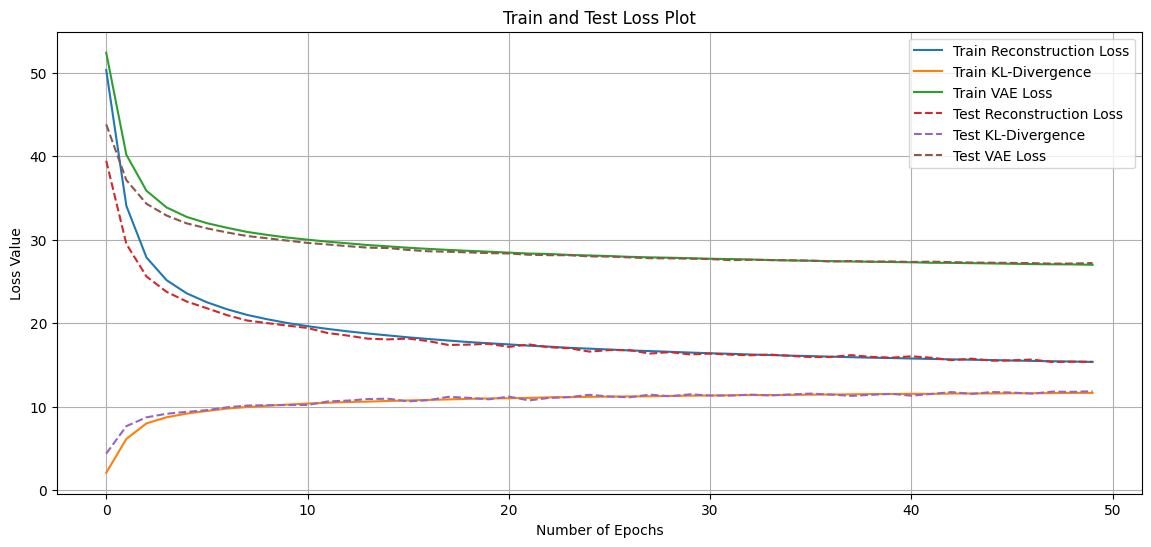

In [8]:
plt.figure(figsize=(14, 6))
plt.title('Train and Test Loss Plot')

# Train losses (solid lines)
plt.plot(reconstruction_losses_avg, label='Train Reconstruction Loss')
plt.plot(kl_divs_avg, label='Train KL-Divergence')
plt.plot(losses_avg, label='Train VAE Loss')

# Test losses (dashed lines)
plt.plot(test_recon_losses_avg, linestyle='--', label='Test Reconstruction Loss')
plt.plot(test_kl_divs_avg, linestyle='--', label='Test KL-Divergence')
plt.plot(test_losses_avg, linestyle='--', label='Test VAE Loss')

plt.xlabel('Number of Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.show()

**Reconstruction of Test Images**

After the model is trained. For testing the reconstructed output from VAE network, training set is input into the network. Both the original test images and reconstructed ones are compared side by side. ```plotfigure(fig)``` is a function which plots the argument fig

In [9]:
def plotfigure(images):
    number_of_images = images.size()[0]
    plt.figure(figsize=(20, 2))
    for i in range(number_of_images):
        plot = plt.subplot(1, number_of_images, i+1)
        plt.imshow(images[i])
        plt.gray()
        plot.get_xaxis().set_visible(False)
        plot.get_yaxis().set_visible(False)
    plt.show()

Original Test Dataset


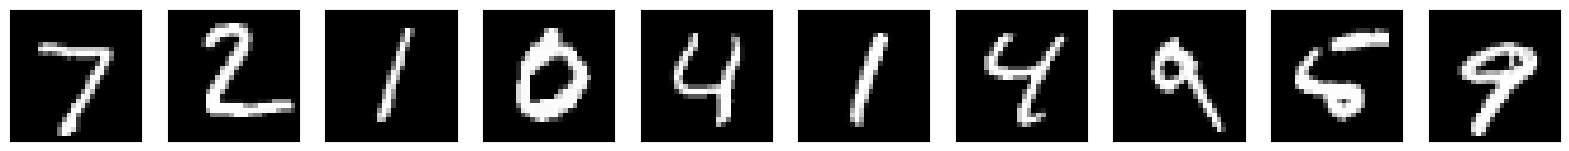

Reconstructed Test Dataset


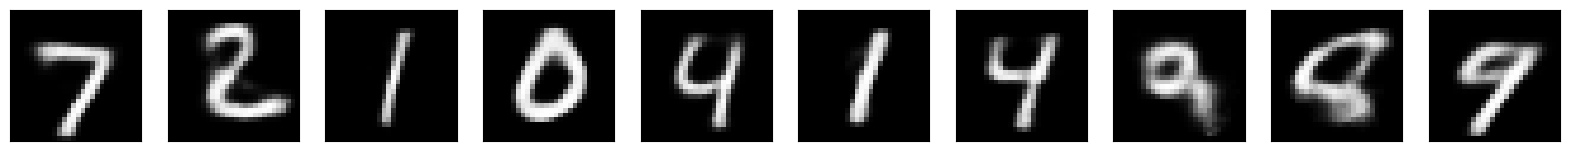

In [10]:
num_examples = 10
samples = next(iter(testloader))[0][:10].to(device)
model.eval()
with torch.no_grad():
    samples_recon, _, _ = model(samples)

samples = samples.squeeze().cpu()
samples_recon = samples_recon.squeeze().cpu()
print('Original Test Dataset')
plotfigure(samples)
print('Reconstructed Test Dataset')
plotfigure(samples_recon)

Generation of new images using VAE

the latent variable are taken at random form standard normal distribution, with dimension = batch_size * h_dim. Then, it is fed into the decoder network and finally reconstructed image is displayed. You can re-run the below code-block (Use ctrl+enter). Each run will give a new generated image. Some of the generated digit might not look like real ones, nevertheless they are generated by the VAE network.

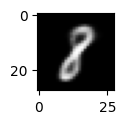

In [11]:
h = torch.randn((1, h_dim), device=device)

model.eval()
with torch.no_grad():
    out = model.decoder(h)
    out = out.squeeze().cpu()

plt.figure(figsize=(1, 1))
plt.imshow(out, cmap='gray')
plt.show()

We have generated digits by the VAE-network.

In [12]:
import matplotlib.colors as mcolors

def plot_latent_space(model, data_loader, device):
    model.eval()
    zs = []
    labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            mean, _ = model.encoder(X_batch)
            zs.append(mean.cpu())
            labels.append(y_batch)

    zs = torch.cat(zs).numpy()
    labels = torch.cat(labels).numpy()

    # MNIST digit labels in ascending order
    mnist_labels = [str(i) for i in range(10)]

    # Colormap and normalization for 10 digits
    cmap = plt.get_cmap('viridis', 10)
    norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, 10, 1), ncolors=10)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(zs[:, 0], zs[:, 1], c=labels, cmap=cmap, norm=norm, s=15, alpha=0.7)

    plt.xlabel("z [0]")
    plt.ylabel("z [1]")
    plt.title("Latent Space Visualization of MNIST Digits")

    # Create colorbar with ticks in the middle of each color
    cbar = plt.colorbar(scatter, ticks=np.arange(10))
    cbar.ax.set_yticklabels(mnist_labels)

    plt.show()

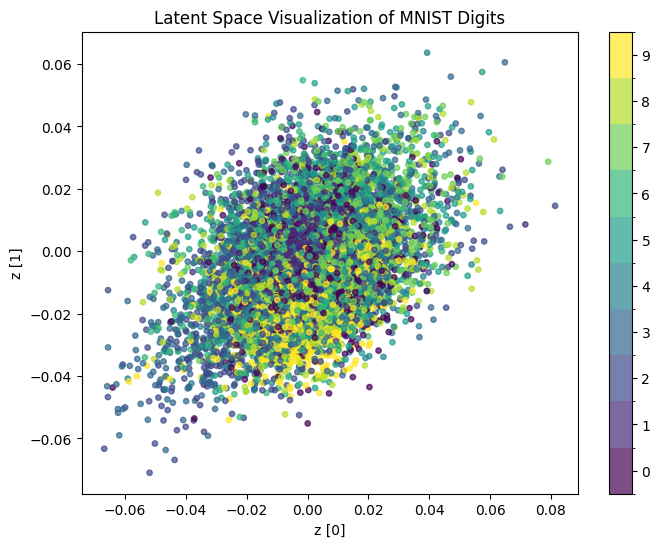

In [13]:
plot_latent_space(model, testloader, device)

Above plot shows the **latent space** where each colored dot represents a MNIST digit. Colors match digits 0–9 in the legend, revealing how the model groups similar digits together in 2D.

**Key Takeaways**

1. Reparametrization trick is used to find the gradient of the loss function which is used to fine-tune the parameters of the network. The latent space variable  $h$  were sampled randomly from our approximate conditional distribution  $qϕ(h|x)$  of the encoder network. The main issue is that the latent variable itself has been a random sample and differentiating it w.r.t the encoder parameters  $ϕ$  is not feasible (high variance).

### **References**

* Articles
    * Weng, Lilian. *From Autoencoder to Beta-VAE*. [lilianweng.github.io](https://lilianweng.github.io/posts/2018-08-12-vae/), 2018.